# Grand Classification Challenge
by Felix Müller & Peter Schrott

The file digits.zip provided contains training and test images of handwritten digits. Each row describes one of the 28x28 pixel sample-images (see a few examples below). The dataset is split in two parts, 500 examples in the training set and 500 examples in the test set. For the training set, the first number represents the target class (i.e. 0-9). For the testset, these assignments are random and can be ignored. The remaining numbers define the image in a sparse representation, i.e., by giving pairs of PixelID:GrayValue where black pixels (GrayValue=0) are not explicitly listed.

In [45]:
# load the modules
import numpy as np
from sidekit.libsvm import svmutil
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.ndimage import interpolation


from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'skimage'

## Load and Inspect the Data Set

Load the dataset using `libsvm` and convert the sparse feature vectors to ndarray. The colors of the digits are inverted, i.e. white strokes on black backgorund. Hence filling up the feature vectors with `0` values for the black background values.

The values of the resulting feature vectors are inverted after. This is mainly for visualisation purpouse and does not bring any advantages during classification of the images.

In [2]:
# helper functions
def convert_to_ndarray(X_in, n_dim=28*28):
    '''
    Synopsis:
        X = convert_to_ndarray(X_raw)
    Arguments:
        X_raw:   list o tuples (pixelID:GreyValue) in a dict of samples 
    Output:
        X:       2D array of non-sparese features (samples x features)
    '''
    X_out = np.zeros((len(X_in), n_dim))
    for i, xi in enumerate(X_in):
        key_list = list(X_in[i].keys())
        value_list = list(X_in[i].values())
        X_out[i,key_list] = value_list
    return X_out

def invert_pixels(X_in):
    '''
    Invert the colors (white strokes -> black strokes).
    
    Synopsis:
        X = invert_pixels(X_in)
    Arguments:
        X_in:   2D array samples (samples x features) 
    Output:
        X:      2D array of non-sparese features (samples x features)
    '''
    X_out = (np.ones(X_in.shape) * 255) - X_in
    
    return X_out

def plot_examples(X, y, title):
    '''
    Plots the frist 12 images of the given data set and their labels.
    
    Synopsis:
        plot_examples(X, y)
    Arguments:
        X:   2D array samples (samples x features) 
        y:   Vector of labels
    '''
    fig = plt.figure(1, figsize=(6*2, 2*2+1))
    plt.suptitle(title)
    for i in range(12):
        ax = fig.add_subplot(2,6,i+1)
        ax.imshow(X[i,:].reshape(28, 28), cmap=plt.cm.gray, interpolation = "none")
        ax.set_title('label: {:d}'.format(y[i]))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [3]:
y_raw, X_raw = svmutil.svm_read_problem('../data/digits/digit_train')
_, X_validation_raw = svmutil.svm_read_problem('../data/digits/digit_test')

X = convert_to_ndarray(X_raw)
X = invert_pixels(X)
y = np.asarray(y_raw).astype(int)
X_validation = convert_to_ndarray(X_validation_raw)
X_validation = invert_pixels(X_validation)

Visualize the 12 first trainings images alongside their labels. Its a good first impression how the data look like.

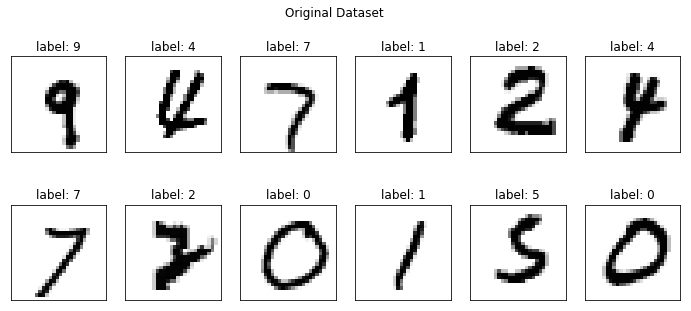

In [4]:
plot_examples(X, y, 'Original Dataset')

## More investigation on the Dataset

### Visualize in 2D
Using PCA to determine the 2 principal components and embedd the trainings data in the reduced 2-dimensional space. A very blurry clustering can already be seen. This is an indication for the separability of the digit classes.

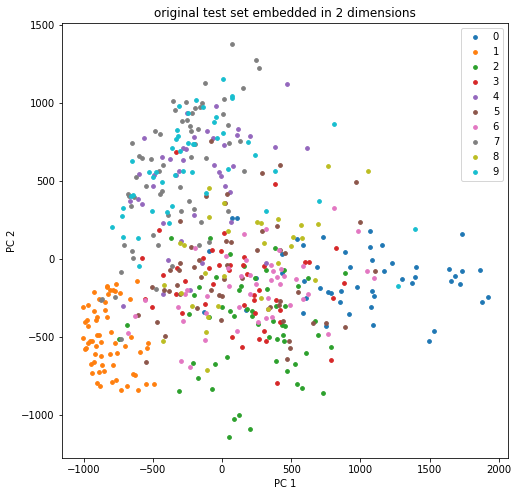

In [5]:
pca = PCA(n_components=2)
pca.fit(X)
X_embedded = pca.transform(X)

plt.figure(figsize=(8, 8))
for d in range(10):
    plt.scatter(X_embedded[y==d,0], X_embedded[y==d,1], s=14, label=d)
plt.clim(0,9)
plt.title("original test set embedded in 2 dimensions")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()

### The principal components spectrum

The spectrum of the principal components shows the percentage of the variance which is explained by a principal components. This analysis is helpful when it comes to choosing the number of principal components to embed the data in. One can see that 90% of the variance is explained by around the first 60 principal components.

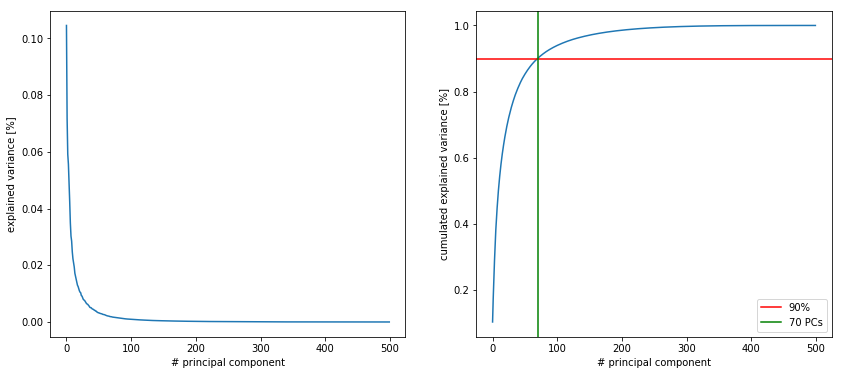

In [6]:
pca = PCA()
pca.fit(X)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cum = explained_variance_ratio.cumsum()
x_90 = next(x[0] for x in enumerate(explained_variance_ratio_cum) if x[1] > 0.9)

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(explained_variance_ratio)
ax1.set_xlabel('# principal component')
ax1.set_ylabel('explained variance [%]')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(explained_variance_ratio_cum)
ax2.axhline(0.9, c='red', label='90%')
ax2.axvline(x_90, c='green', label='{:d} PCs'.format(x_90))
ax2.set_xlabel('# principal component')
ax2.set_ylabel('cumulated explained variance [%]')
ax2.legend()
plt.show()

## Expand the dataset

Due to the fact that the dataset was reduced for the callenge, we extend the number of samples artificially. Only 500 samples were given to train the classifyer. With the extention of the dataset we expect a better generalization of the model which leads to a better out of sample prediction on the provided validation dataset. This prediciton is used to assess the model by the authorities. 

Two apporoaches are choosen to expand the dataset:
1. Rotate the digits within every picture. This feels somehow natrual as the tilt of handwritten digits among people differs.
2. Shift the digits by some pixels. As it can be seen in the first visualizations, the digits are not always in the very center (compare the two 7s).

Of course one can come up very more sophisticated extentions of the dataset, e.g. zooming or creating artifical digit images based on averages or principal components of one digit class.

After the modification of the handwritten image data, we choose to visualize the same images again to get a feeling about the choosen parameter and the resulting outcome. Finally the same visualisation of embedding as above is done. It can bee seen that the clustring is maintained and even gets more dense.

In [30]:
# helper functions
def rotate_digits(X_in, angle):
    '''
    Rotates every digit image by the given angle.
    
    Synopsis:
        X_rot = rotate_digits(X, 10)
    Arguments:
        X:       2D array samples (samples x features) 
        angle:   The rotation angle
    '''
    X_out = np.empty(X_in.shape)
    for i, x_i in enumerate(X_in):
        x_i = x_i.reshape(28, 28)
        x_i_rotated = interpolation.rotate(x_i, angle=angle, cval=255)
        start_idx = int((x_i_rotated.shape[0]-28)/2)
        end_idx = start_idx + 28
        x_i_rotated = x_i_rotated[start_idx:end_idx,start_idx:end_idx]
        x_i_rotated[x_i_rotated > 250] = 255
        x_i_rotated[x_i_rotated < 5] = 0
        X_out[i, :] = x_i_rotated.reshape(1, 28*28)
    return X_out

def shift_digits(X_in, n_pixel_x, n_pixel_y):
    '''
    Shifts every digit image by the given number of pixel in according direction.
    
    Synopsis:
        X_shift = shift_digits(X, 0, 2)
    Arguments:
        X:           2D array samples (samples x features) 
        n_pixel_x:   number of pixels in x direction
        n_pixel_y:   number of pixels in y direction
    '''
    X_out = np.empty(X_in.shape)
    for i, x_i in enumerate(X_in):
        x_i = x_i.reshape(28, 28)
        x_i_shift = interpolation.shift(x_i, shift=[-n_pixel_y, n_pixel_x], cval=255)
        X_out[i, :] = x_i_shift.reshape(1, 28*28)
    return X_out


def binary_digits(X_in):
    X_out = np.empty(X_in.shape)
    for i, x_i in enumerate(X_in):
        x_i = x_i.reshape(28, 28)
        x_i_rotated = x_i
        start_idx = int((x_i_rotated.shape[0]-28)/2)
        end_idx = start_idx + 28
        x_i_rotated = x_i_rotated[start_idx:end_idx,start_idx:end_idx]
        x_i_rotated[x_i_rotated > 128] = 255
        x_i_rotated[x_i_rotated < 128] = 0
        X_out[i, :] = x_i_rotated.reshape(1, 28*28)
    return X_out

In [43]:
X_rot_p = rotate_digits(X, 10)
X_rot_n = rotate_digits(X, -10)
X_shift_r = shift_digits(X, 2, 0)
X_shift_l = shift_digits(X, -2, 0)

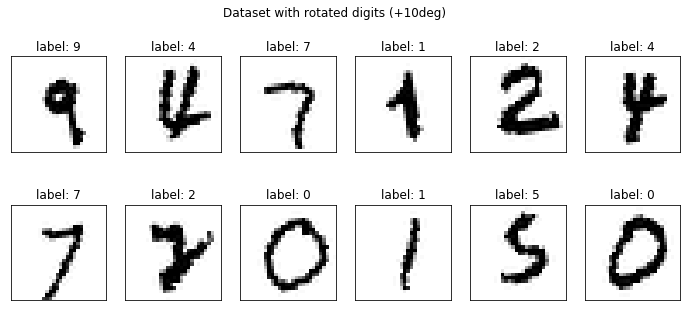

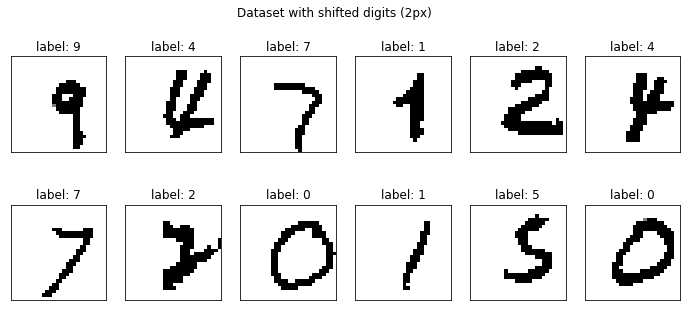

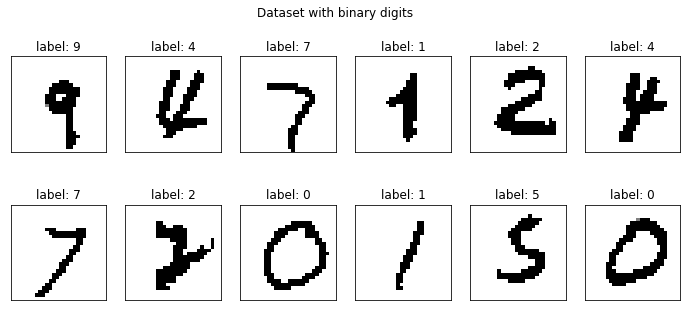

In [37]:
# visualize the modified dataset to get an idea what happend
plot_examples(X_rot_p, y, 'Dataset with rotated digits (+10deg)')
plot_examples(X_shift_r, y, 'Dataset with shifted digits (2px)')

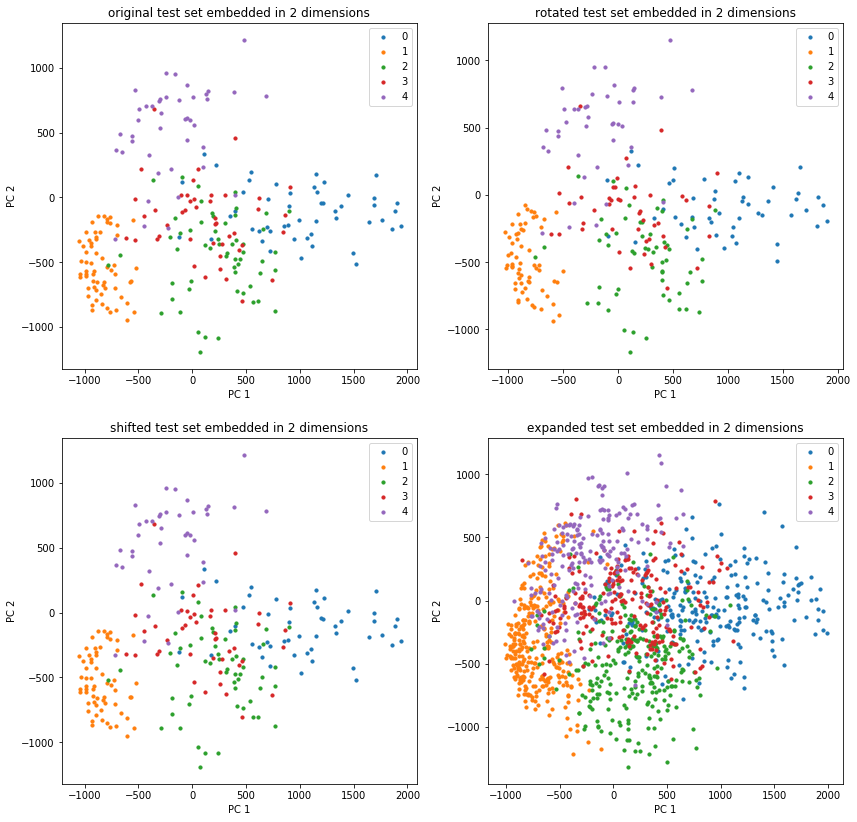

In [38]:
X_exp = np.vstack((X_rot_n, X_rot_p, X_shift_l, X_shift_r, X))
y_exp = np.tile(y, 5)

plot_list = [(X, y, 'original test set embedded in 2 dimensions'), 
            (X_rot_p, y, 'rotated test set embedded in 2 dimensions'), 
            (X_shift_r, y, 'shifted test set embedded in 2 dimensions'), 
            (X_exp, y_exp, 'expanded test set embedded in 2 dimensions')]
n_digits = 5

fig = plt.figure(figsize=(14, 14))

for i, (X_tmp, y_tmp, title) in enumerate(plot_list):
    pca = PCA(n_components=2)
    pca.fit(X_tmp)
    X_embedded = pca.transform(X_tmp)
    ax = fig.add_subplot(2,2,i+1)
    for d in range(n_digits):
        ax.scatter(X_embedded[y_tmp==d,0], X_embedded[y_tmp==d,1], s=10, label=d)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_title(title)
    ax.legend()

# Classification

For the classification two approaches are choosen. First, we use a ensamble of PCA and KNN in a two step approach. First reduce the dimensionality of the dataset with PCA, then perform a classification by K-Nearest-Neighbor algorightm. Secondly Decssion Trees in a Random Forest are trained and evaluated.

In [39]:
# helper functions
def crossvalidation(clf, X, y, n_folds=8):
    score_array = np.empty((n_folds, 1))
    kf = KFold(n_splits=n_folds)
    for ff, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        # fit the model
        clf.fit(X_train, y_train)
        # predict and meassure the error
        score_array[ff] = clf.score(X_test, y_test)

    return np.mean(score_array)

def plot_two_params_score(score_array, x, y, xlabel, ylabel, classifier_name):
    plt.imshow(score_array.T, interpolation='none')
    plt.xticks(np.arange(x.shape[0]), x, rotation='vertical')
    plt.yticks(np.arange(y.shape[0]), y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Score of {} [best={:4f}]'.format(classifier_name, score_array.max()))
    plt.colorbar()

## Classification with KNN powerd by PCA

In this section we evaluate the performance of digit-recognition by KNN. We perform grid-search over the amount of neighbours in KNN and the number of Components used for PCA. We calculate the performance with cross-validation and afterwards plot the performance over the parameters to determine the best factors.

The parameters are the following:
$$ neighbours \in [2,3,4,...,11,12] $$ and $$ components \in [1,2,3,4,5,10,20,50,100,200,500]$$ 

In [40]:
n_pc_array = np.array([1,2,3,4,5,10,20,50,100,200,500])
n_neighbors_array = np.arange(2, 12, 1)
score_array = np.zeros((n_pc_array.shape[0], n_neighbors_array.shape[0]))

for i, n_pc in enumerate(n_pc_array):
    for j, n_neighbors in enumerate(n_neighbors_array):
        pca = PCA(n_components=n_pc, whiten=True)
        pca.fit(X_exp)
        X_embedded = pca.transform(X_exp)
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        score_array[i,j] = crossvalidation(knn, X_embedded, y_exp)

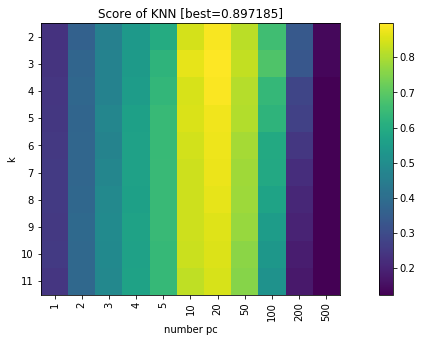

In [41]:
fig = plt.figure(1)   
fig.set_size_inches((14, 5))
plot_two_params_score(score_array, n_pc_array, n_neighbors_array, 'number pc', 'k', 'KNN')
plt.show()

## Classification with RandomForest

In this section we evaluate the performance of digit-recognition by Random-Forests. We perform grid-search over the amount of leafs and the number of estimators. We use the numpy-intern function GridSearchCV to get the performance and plot it over the parameters to determine the best factors.

The parameters are the following:
$$ leafs \in [2,3,4,5] $$ 
and 
$$ estimators \in [10,50,100,200,500,1000]$$ 

In [44]:
n_estimators_array = np.array([10,50,100,200,500,1000])
min_samples_leaf_array = np.arange(2, 5, 1)
score_array = np.zeros((n_estimators_array.shape[0], min_samples_leaf_array.shape[0]))
tuned_parameters = [{
    'n_estimators': n_estimators_array, 
    'min_samples_leaf': min_samples_leaf_array
}]
rf = RandomForestClassifier(criterion="gini")
clf = GridSearchCV(rf, tuned_parameters, cv=8)
clf.fit(X_exp, y_exp)
score_array = np.asarray(clf.cv_results_['mean_test_score']) \
    .reshape(n_estimators_array.shape[0], min_samples_leaf_array.shape[0])

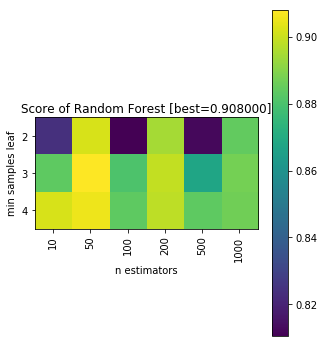

In [15]:
fig = plt.figure(1)   
fig.set_size_inches((5, 6))
plot_two_params_score(score_array, n_estimators_array, min_samples_leaf_array, 
                      'n estimators', 'min samples leaf', 'Random Forest')
plt.show()

## Prediction on the Validation Set

As the Random Forest Classifier turns out to have a slightly better Performance, we use it to determine the labels for the Validation set.

In [16]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, criterion="gini")
clf.fit(X_exp, y_exp)
y_pred = clf.predict(X_validation)

# save the results on a text file
np.savetxt('felix-peter.txt',  y_pred, fmt='%d')